<img src = "https://github.com/singlestore-labs/spaces-notebooks/blob/e551e274bb67bb1e5081131ee1150cdba713fc43/common/images/singlestore-jupyter.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Movie Recommender Part 3</h1>
    </div>
</div>

In [12]:
!pip cache purge --quiet

In [13]:
!pip install matplotlib --quiet
!pip install scikit-learn --quiet
!pip install seaborn --quiet

In [14]:
!conda install -y --quiet -c conda-forge scikit-surprise

Solving environment: ...working... done

# All requested packages already installed.



In [15]:
import pandas as pd
import numpy as np

# Load Data

In [16]:
extract_dirs = [
    "posters",
    "datasets"
]

In [17]:
movies_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/movies.csv"
)

users_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/users.csv"
)

ratings_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/ratings.csv"
)

# Build Initial Model
## Create Train-Test Split

**TL;DR**<br>
Set up the data and default parameters for training an SVD model to predict user ratings of movies.

**Summary**<br>
Singular Value Decomposition (SVD) is a mathematical technique used in various applications, including recommendation systems. In recommendation systems, SVD is used for matrix factorisation, which helps in predicting missing entries in a user-item rating matrix.

```
       | Movie1 | Movie2 | Movie3 |
-------+--------+--------+--------+
 User1 |   5    |   3    |        |
-------+--------+--------+--------+
 User2 |        |        |   4    |
-------+--------+--------+--------+
 User3 |   1    |        |   2    |
-------+--------+--------+--------+
```

In [18]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD

reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(
    ratings_df[["user_id", "movie_id", "rating"]],
    reader
)

train, test = train_test_split(
    data,
    test_size = 0.3,
    random_state = 42
)

# Set default values for best_params
best_params = {
    "n_factors": 100,
    "reg_all": 0.05,
    "n_epochs": 40
}

## Hyperparameter Tuning

**TL;DR**<br>
Perform hyperparameter tuning for an SVD model using GridSearchCV to find the best parameters that minimize RMSE in a movie recommendation system.

**Summary**<br>
The code uses the GridSearchCV class from the Surprise library to perform hyperparameter tuning for an SVD model in a movie recommendation system. A parameter grid is defined, specifying various values for the number of latent factors, regularisation term, and number of epochs. The grid search is set up to evaluate the model using **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)** metrics, with 3-fold cross-validation. The grid search is executed on the dataset, and the best parameters for minimizing RMSE are identified and printed, along with the best RMSE score.

- **n_factors:** The number of latent factors in the model. Latent factors represent underlying patterns or features in the data. Increasing the number of factors can improve the model's ability to capture complex relationships, but may also increase the risk of overfitting.
- **reg_all:** The regularisation term. This parameter helps to prevent overfitting by penalising large values in the latent factor matrices. A higher regularisation term reduces the magnitude of latent factors, promoting simpler models.
- **n_epochs:** The number of iterations or epochs. This parameter determines how many times the algorithm will process the entire training dataset. More epochs can lead to better convergence and model performance, but too many epochs can lead to overfitting.

In [19]:
# from surprise.model_selection import GridSearchCV

# param_grid = {
#     "n_factors": [50, 100, 150, 200],
#     "reg_all": [0.01, 0.02, 0.05, 0.1],
#     "n_epochs": [10, 20, 30, 40]
# }

# # Define the grid search with the model and parameter grid
# gs = GridSearchCV(SVD, param_grid, measures = ["rmse", "mae"], cv = 3)

# # Run the grid search on the data
# gs.fit(data)

# # Get the best parameters
# best_params = gs.best_params["rmse"]

# # Print the best RMSE score and best parameters
# print(f"Best RMSE score: {gs.best_score['rmse']}")
# print(f"Best parameters: {best_params}")

## Create Model

**TL;DR**<br>
Initialise and train an SVD model with the best hyperparameters from a grid search on the training dataset.

**Summary**<br>
Initialise an SVD model using the best parameters obtained from a previous grid search. These parameters include the number of latent factors, regularisation term, and number of epochs. Additionally, a fixed random state is set for reproducibility. The model is then trained using the training dataset.

In [20]:
# Initialise the SVD model with the best parameters
model = SVD(
    n_factors = best_params["n_factors"],
    reg_all = best_params["reg_all"],
    n_epochs = best_params["n_epochs"],
    random_state = 0
)

model.fit(train)

## Create Predictions

**TL;DR**<br>
Generate and store predictions from the trained SVD model on the test dataset, creating a DataFrame with user ID, movie ID, actual rating, and predicted rating, then display the first few rows.

**Summary**<br>
Use the trained SVD model to make predictions on the test dataset, generating predicted ratings for each user-item pair. These predictions are then stored in a DataFrame with columns for user ID, movie ID, actual rating, and predicted rating. The *details* column, which contains additional information about the prediction process, is removed from the DataFrame. Finally, the first few rows of the DataFrame are displayed.

In [21]:
predictions = model.test(test)

predictions_df = pd.DataFrame(
    predictions,
    columns = ["user_id", "movie_id", "rating", "prediction", "details"]
)

predictions_df.drop(columns = ["details"], inplace = True)

predictions_df.head()

,user_id,movie_id,rating,prediction
0,3718,1234,3.0,3.530504
1,4048,1937,5.0,4.222786
2,5074,1458,1.0,3.409988
3,5502,608,4.0,4.120036
4,1903,596,4.0,3.672289


## Metrics

**TL;DR**<br>
Computes RMSE, MAE, MSE, and FCP metrics to evaluate the accuracy of the SVD model's predictions.

**Summary**<br>
Calculate various accuracy metrics for the predictions made by the SVD model on the test dataset. Compute the **Root Mean Squared Error (RMSE)**, **Mean Absolute Error (MAE)**, **Mean Squared Error (MSE)**, and the **Fraction of Concordant Pairs (FCP)** for the predicted ratings. These metrics provide different perspectives on the accuracy and quality of the model's predictions.

- **RMSE (Root Mean Squared Error):** Measures the square root of the average squared differences between predicted and actual ratings. Lower values indicate better predictive accuracy.
- **MAE (Mean Absolute Error):** Measures the average absolute differences between predicted and actual ratings. Lower values indicate more accurate predictions.
- **MSE (Mean Squared Error):** Measures the average squared differences between predicted and actual ratings. It is similar to RMSE but without taking the square root. Lower values indicate better accuracy.
- **FCP (Fraction of Concordant Pairs):** Measures the fraction of correctly ordered pairs of ratings. Higher values indicate better model performance in ranking items accurately.

In [22]:
from surprise import accuracy

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
mse = accuracy.mse(predictions)
fcp = accuracy.fcp(predictions)

RMSE: 0.8614
MAE:  0.6780
MSE: 0.7420
FCP:  0.7586


# Visualisations

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

# Assuming we have predictions and actual ratings
y_true = [true_r for (_, _, true_r, _, _) in predictions]
y_pred = [est for (_, _, _, est, _) in predictions]

# Convert ratings to binary relevance
threshold = 3.5
y_true_binary = [1 if rating >= threshold else 0 for rating in y_true]
y_pred_binary = [1 if rating >= threshold else 0 for rating in y_pred]

## Precision-Recall Curve

**TL;DR**<br>
Plot a **Precision-Recall Curve** to assess a binary classifier's performance, showing the relationship between precision (*y-axis*) and recall (*x-axis*) across different decision thresholds.

**Summary**<br>
Generate a **Precision-Recall Curve (PR Curve)** to evaluate the performance of a binary classification model. Compute precision and recall values based on true binary labels (*y_true_binary*) and predicted probabilities (*y_pred*). The curve illustrates the trade-off between precision (the ability of the classifier not to label as positive a sample that is negative) and recall (the ability of the classifier to find all positive samples). The plot visualises how varying the decision threshold affects both precision and recall, providing insights into the model's capability to balance between correctly identifying positives and minimizing false positives.

- **Precision:** Precision is the ratio of true positive predictions to all positive predictions made by the model. It measures how many of the predicted positive instances are actually positive.
- **Recall:** Recall is the ratio of true positive predictions to all actual positive instances in the dataset. It measures the model's ability to correctly identify all positive instances.

A good classifier strives to achieve high precision and recall simultaneously, as represented by a curve that hugs the upper-right corner of the plot.

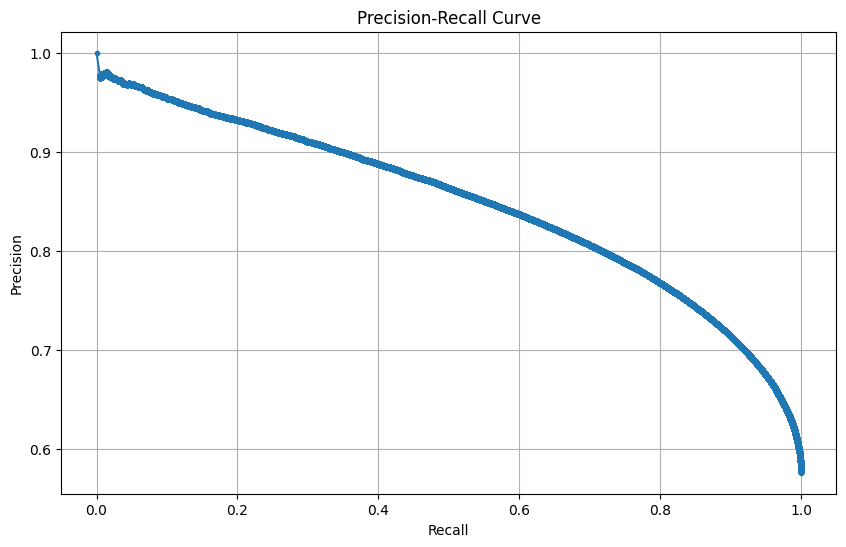

In [24]:
precision, recall, _ = precision_recall_curve(y_true_binary, y_pred)
plt.figure(figsize = (10, 6))
plt.plot(
    recall,
    precision,
    marker = "."
)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.grid(True)
plt.show()

## ROC Curve and AUC

**TL;DR**<br>
Plot an ROC Curve to assess a binary classifier's performance, depicting the trade-off between **True Positive Rate** and **False Positive Rate** across different decision thresholds, with AUC indicating overall model performance.

**Summary**<br>
This code generates a **Receiver Operating Characteristic (ROC) Curve** to evaluate the performance of a binary classification model. It computes the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** based on true binary labels (*y_true_binary*) and predicted probabilities (*y_pred*). The ROC curve illustrates the trade-off between sensitivity (TPR) and specificity (1 - FPR) across various decision thresholds. The **Area Under the Curve (AUC)** quantifies the overall performance of the model; higher AUC values indicate better discrimination between positive and negative classes. This plot helps visualise how well the model distinguishes between classes and identifies an optimal threshold for classification.

- **True Positive Rate (TPR):** TPR measures the proportion of actual positive instances correctly predicted by the model (sensitivity).
- **False Positive Rate (FPR):** FPR measures the proportion of actual negative instances incorrectly predicted as positive by the model (1 - specificity).

A diagonal line (from bottom-left to top-right) represents random guessing, and a curve closer to the top-left corner indicates better model performance. The AUC (Area Under the Curve) quantifies the ROC curve's overall performance: an AUC closer to 1.0 suggests better model discrimination, while an AUC of 0.5 implies a model that performs no better than random guessing.

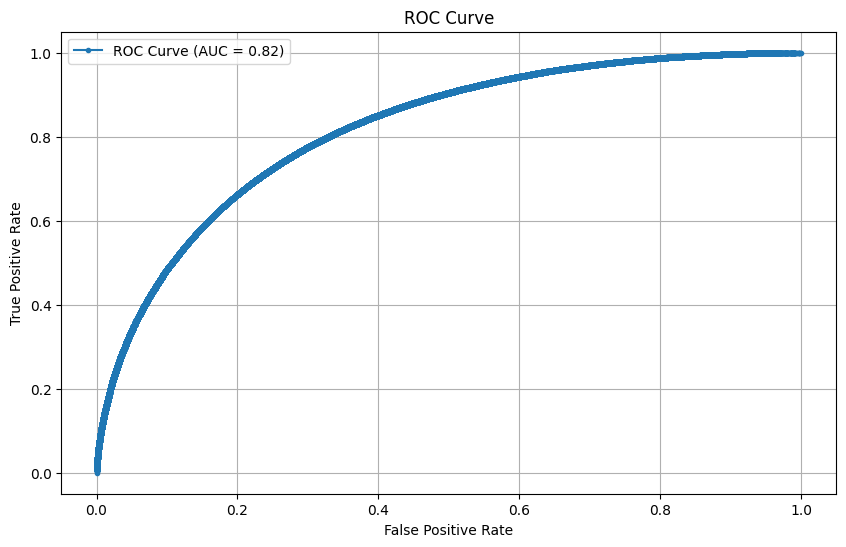

In [25]:
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (10, 6))
plt.plot(
    fpr,
    tpr,
    marker = ".",
    label = f"ROC Curve (AUC = {roc_auc:.2f})"
)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.grid(True)
plt.show()

## Confusion Matrix

**TL;DR**<br>
Converts ratings to binary relevance based on a threshold, constructs and displays a **Confusion Matrix** to assess the model's classification performance.

**Summary**<br>
Generates a **Confusion Matrix** to evaluate the performance of a binary classification model. First, onvert the true and predicted ratings into binary relevance based on a threshold (3.5). Ratings above or equal to the threshold are labelled as *Positive*, while ratings below the threshold are labelled as *Negative*. The confusion matrix visualises the counts of actual versus predicted labels, helping to assess the model's accuracy in distinguishing between positive and negative instances. Annotations within the matrix show the number of predictions in each category, with a heatmap coloring scheme to highlight different levels of correctness in predictions.

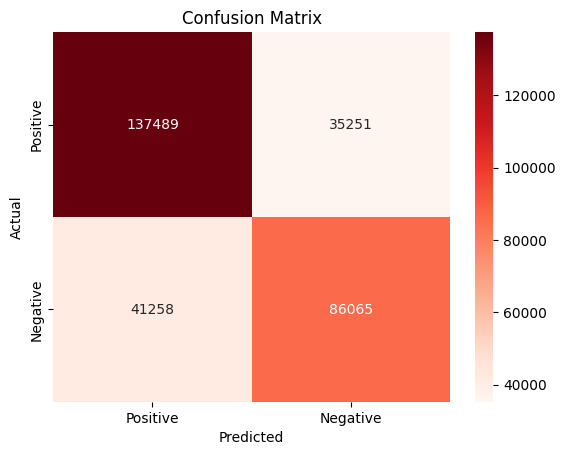

In [26]:
# Convert ratings to binary relevance
threshold = 3.5
# Convert ratings to binary relevance
y_true_binary = ["Positive" if rating >= threshold else "Negative" for rating in y_true]
y_pred_binary = ["Positive" if rating >= threshold else "Negative" for rating in y_pred]

cm = confusion_matrix(
    y_true_binary,
    y_pred_binary,
    labels = ["Positive", "Negative"]
)

sns.heatmap(
    cm,
    annot = True,
    fmt = "d",
    cmap = "Reds",
    xticklabels = ["Positive", "Negative"],
    yticklabels = ["Positive", "Negative"]
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

## Coverage and Diversity

**TL;DR**<br>
Calculates and prints **User Coverage**, indicating the percentage of users with recommendations, and **Item Diversity**, indicating the percentage of unique items recommended compared to the total available.

**Summary**<br>
Calculates two evaluation metrics for a recommendation system based on predictions made by the model.

- **User Coverage:** It measures the proportion of unique users for whom the system can generate recommendations. It computes the ratio of users with at least one recommendation to the total number of unique users in the dataset.
- **Item Diversity:** This metric assesses the variety of items recommended by the system. It calculates the ratio of unique recommended items to the total number of unique items in the dataset.

These metrics help assess the effectiveness and inclusiveness of a recommendation system, ensuring it provides valuable recommendations to a diverse user base across a wide array of items.

In [27]:
# User Coverage
unique_users = ratings_df["user_id"].nunique()
users_with_recommendations = len(set([uid for uid, _, _, _, _ in predictions]))
user_coverage = users_with_recommendations / unique_users
print(f"User Coverage: {user_coverage:.2%}")

# Item Diversity
recommended_items = set([iid for _, iid, _, _, _ in predictions])
total_items = ratings_df["movie_id"].nunique()
item_diversity = len(recommended_items) / total_items
print(f"Item Diversity: {item_diversity:.2%}")

User Coverage: 100.00%
Item Diversity: 95.66%


# Data Preparation

**TL;DR**<br>
The code maps the internal IDs used by the Surprise library back to the original user and item IDs from the dataset.

**Summary**<br>
The code maps internal IDs used by the Surprise library back to the original user and item IDs from the dataset. It creates dictionaries to convert inner user and item IDs to their corresponding raw IDs. This mapping is essential for interpreting the model's factors in terms of the original dataset IDs.

In [28]:
raw_user_id_mapping = {inner_id: train.to_raw_uid(inner_id) for inner_id in range(train.n_users)}
raw_item_id_mapping = {inner_id: train.to_raw_iid(inner_id) for inner_id in range(train.n_items)}

## Prepare User Factors

**TL;DR**<br>
Create a DataFrame to explore user factors learned by the SVD model, mapping them to original user IDs and sorting for analysis.

**Summary**<br>
Extract and organise user factors (latent features) learned by the SVD model into a DataFrame for analysis. Access the user factors (*pu*) from the trained model and map them back to their original user IDs. The resulting DataFrame (*user_factors_df*) includes columns for user IDs and their corresponding latent factors represented as arrays of floating-point numbers. Sorting by user ID ensures that the DataFrame displays factors in a logical order.

In [29]:
user_factors = model.pu

user_factors_df = pd.DataFrame({
    "id": [raw_user_id_mapping[idx] for idx in range(user_factors.shape[0])],
    "factors": [np.array(factor, dtype = np.float32) for factor in user_factors]
})

user_factors_df.sort_values(by = "id", inplace = True)

user_factors_df.head()

,id,factors
4163,1,"[0.0026607865, -0.029349634, 0.023931202, 0.03..."
907,2,"[0.04819945, -0.057750683, 0.15398903, -0.2038..."
1642,3,"[-0.062272433, -0.084226236, 0.06741777, 0.101..."
5507,4,"[-0.14041558, 0.10384874, -0.097525865, -0.006..."
3394,5,"[-0.055100366, -0.1710061, -0.23063144, 0.0632..."


## Prepare Item Factors

**TL;DR**<br>
Create a DataFrame to explore item factors learned by the SVD model, mapping them to original item IDs and sorting for analysis.

**Summary**<br>
Extract and organise item factors (latent features) learned by the SVD model into a DataFrame for analysis. Access the item factors (*qi*) from the trained model and map them back to their original item IDs. The resulting DataFrame (*item_factors_df*) includes columns for item IDs and their corresponding latent factors represented as arrays of floating-point numbers. Sorting by item ID ensures that the DataFrame displays factors in a logical order.

In [30]:
item_factors = model.qi

item_factors_df = pd.DataFrame({
    "id": [raw_item_id_mapping[idx] for idx in range(item_factors.shape[0])],
    "factors": [np.array(factor, dtype = np.float32) for factor in item_factors]
})

item_factors_df.sort_values(by = "id", inplace = True)

item_factors_df.head()

,id,factors
821,1,"[0.04627702, 0.09863553, -0.06104441, -0.03069..."
628,2,"[-0.08745112, -0.09041161, -0.019114513, 0.221..."
1638,3,"[-0.071723305, 0.047078338, 0.0965642, 0.09836..."
1379,4,"[0.009337103, 0.005654531, 0.06739552, -0.0427..."
1876,5,"[-0.19316173, 0.055749703, 0.09433051, 0.02395..."


## Merge User Factors with Users

**TL;DR**<br>
Merge user data with user factors from a recommendation model based on user IDs, allowing for a comprehensive analysis of user preferences and characteristics.

**Summary**<br>
Merge user data (*users_df*) with user factors (*user_factors_df*) obtained from a recommendation model using the user IDs as the key. The merge operation combines information about users' demographic or contextual data with the learned latent factors from the model. The resulting DataFrame (*users_df*) includes both original user data and an additional column for user factors, enabling richer analysis of how user characteristics influence their preferences in the recommendation system.

In [31]:
users_df = pd.merge(
    users_df,
    user_factors_df,
    on = "id",
    how = "left"
)

users_df.head()

,id,gender,age,zip_code,occupation,factors
0,1,F,1,48067,K-12 student,"[0.0026607865, -0.029349634, 0.023931202, 0.03..."
1,2,M,56,70072,self-employed,"[0.04819945, -0.057750683, 0.15398903, -0.2038..."
2,3,M,25,55117,scientist,"[-0.062272433, -0.084226236, 0.06741777, 0.101..."
3,4,M,45,02460,executive/managerial,"[-0.14041558, 0.10384874, -0.097525865, -0.006..."
4,5,M,25,55455,writer,"[-0.055100366, -0.1710061, -0.23063144, 0.0632..."


## Merge Item factors with Movies

**TL;DR**<br>
Merge movie data with item factors from a recommendation model based on item IDs, allowing detailed analysis of movie features and their impact on recommendations.

**Summary**<br>
Merge movie data (*movies_df*) with item factors (*item_factors_df*) obtained from a recommendation model using the item IDs as the key. The merge operation combines information about movies' attributes or characteristics with the learned latent factors from the model. The resulting DataFrame (*movies_df*) includes both original movie data and an additional column for item factors, allowing for a comprehensive analysis of how movie features influence recommendations in the system.

In [32]:
movies_df = pd.merge(
    movies_df,
    item_factors_df,
    on = "id",
    how = "left"
)

movies_df.head()

,id,title,genres,poster,factors
0,1,Toy Story (1995),Animation|Children's|Comedy,https://m.media-amazon.com/images/M/MV5BMDU2ZW...,"[0.04627702, 0.09863553, -0.06104441, -0.03069..."
1,2,Jumanji (1995),Adventure|Children's|Fantasy,https://m.media-amazon.com/images/M/MV5BZTk2Zm...,"[-0.08745112, -0.09041161, -0.019114513, 0.221..."
2,3,Grumpier Old Men (1995),Comedy|Romance,https://m.media-amazon.com/images/M/MV5BMjQxM2...,"[-0.071723305, 0.047078338, 0.0965642, 0.09836..."
3,4,Waiting to Exhale (1995),Comedy|Drama,https://m.media-amazon.com/images/M/MV5BYzcyMD...,"[0.009337103, 0.005654531, 0.06739552, -0.0427..."
4,5,Father of the Bride Part II (1995),Comedy,https://m.media-amazon.com/images/M/MV5BOTEyNz...,"[-0.19316173, 0.055749703, 0.09433051, 0.02395..."


# Write Data to the Database

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [33]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [34]:
%%sql
TRUNCATE TABLE users;
TRUNCATE TABLE movies;
TRUNCATE TABLE ratings;

++
||
++
++

In [35]:
%config SqlMagic.named_parameters = True

In [36]:
n_factors = best_params["n_factors"]

In [37]:
%%sql
ALTER TABLE users MODIFY COLUMN factors VECTOR(:n_factors);
ALTER TABLE movies MODIFY COLUMN factors VECTOR(:n_factors);

++
||
++
++

## Write Users Data

In [38]:
users_df.to_sql(
    "users",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

6040

## Write Movies Data

In [39]:
movies_df.to_sql(
    "movies",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

3883

## Write Ratings Data

In [40]:
ratings_df.to_sql(
    "ratings",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

1000209